<a href="https://colab.research.google.com/github/Fernsrea/flow_matching/blob/main/DeterministicMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import random
import cv2

def generate_free_form_mask(height=28, width=28, max_strokes=5, max_vertex=5, max_angle=360, max_length=12, max_brush_width=4):
    mask = np.ones((height, width), np.uint8)
    num_strokes = random.randint(1, max_strokes)

    for _ in range(num_strokes):
        num_vertex = random.randint(1, max_vertex)
        start_y = random.randint(0, height - 1)
        start_x = random.randint(0, width - 1)

        brush_width = random.randint(1, max_brush_width)
        angle = random.uniform(0, 2 * np.pi)
        length = random.randint(4, max_length)

        points = []
        for _ in range(num_vertex):
            angle += random.uniform(-max_angle, max_angle) * np.pi / 180
            dx = int(length * np.cos(angle))
            dy = int(length * np.sin(angle))

            next_x = np.clip(start_x + dx, 0, width - 1)
            next_y = np.clip(start_y + dy, 0, height - 1)

            cv2.line(mask, (start_x, start_y), (next_x, next_y), 0, brush_width)
            start_x, start_y = next_x, next_y

    return mask

In [4]:
import torch
from torchvision import datasets, transforms

class MNISTWithFreeFormMask(torch.utils.data.Dataset):
    def __init__(self, train=True, mask_prob=1.0):
        self.dataset = datasets.MNIST(
            root='./data', train=train, download=True, transform=transforms.ToTensor()
        )
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img_np = img.squeeze(0).numpy()

        if random.random() < self.mask_prob:
            mask = generate_free_form_mask(28, 28)
            img_np *= mask
        else:
            mask = np.ones_like(img_np)

        return torch.tensor(img_np).unsqueeze(0).float(), torch.tensor(mask).unsqueeze(0).float(), label

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


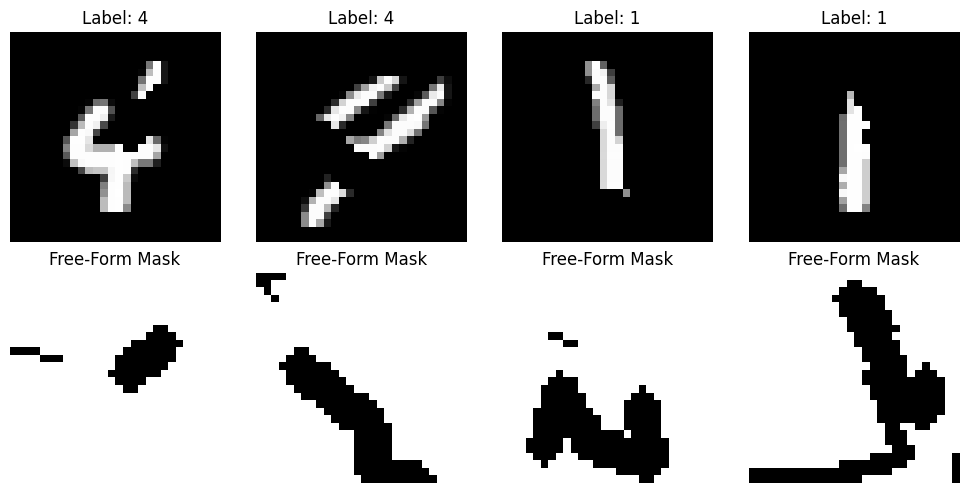

In [5]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = MNISTWithFreeFormMask(train=True)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

imgs, masks, labels = next(iter(loader))

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for i in range(4):
    axs[0, i].imshow(imgs[i].squeeze(), cmap='gray')
    axs[0, i].set_title(f"Label: {labels[i].item()}")
    axs[1, i].imshow(masks[i].squeeze(), cmap='gray')
    axs[1, i].set_title("Free-Form Mask")
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.tight_layout()
plt.show()

In [4]:
import os
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image

# Parameters
collage_output_dir = "./data/image_generation_Collage/"
individual_output_dir = "./data/image_generation_Individual/" # New directory for individual images
mask_size = 12  # size of the center square to mask
image_size = 28
collage_batch_size = 64 # Number of images to include in each collage

# Create output directories
os.makedirs(collage_output_dir, exist_ok=True)
os.makedirs(individual_output_dir, exist_ok=True) # Create the new directory

# Load MNIST dataset
transform = transforms.ToTensor()
mnist = MNIST(root="./data", train=True, download=True, transform=transform)

# Define deterministic center mask
def create_center_mask(size, mask_size):
    mask = np.ones((size, size), dtype=np.float32)
    start = (size - mask_size) // 2
    mask[start:start + mask_size, start:start + mask_size] = 0
    return torch.from_numpy(mask).unsqueeze(0)

mask_tensor = create_center_mask(image_size, mask_size)

# List to accumulate masked images for collage
collage_images = []
collage_count = 0

# Apply mask and collect images for collage
for idx, (img_tensor, _) in enumerate(mnist):
    masked_img_tensor = img_tensor * mask_tensor

    # Save individual masked image
    save_image(masked_img_tensor, os.path.join(individual_output_dir, f"{idx:05d}.png"))

    collage_images.append(masked_img_tensor)

    # If we have enough images for a collage, save it
    if len(collage_images) == collage_batch_size:
        # Stack the list of tensors into a single batch tensor
        batch_tensor = torch.stack(collage_images)
        # Save the collage image
        save_image(batch_tensor, os.path.join(collage_output_dir, f"collage_{collage_count:05d}.png"))
        print(f"Saved collage {collage_count} with {collage_batch_size} images.")

        # Reset for the next collage
        collage_images = []
        collage_count += 1

    if idx % 1000 == 0:
        print(f"Processed {idx} images (individual and for collages)...")

# Save any remaining images as a final collage if the last batch is not full
if len(collage_images) > 0:
    batch_tensor = torch.stack(collage_images)
    save_image(batch_tensor, os.path.join(collage_output_dir, f"collage_{collage_count:05d}_final.png"))
    print(f"Saved final collage {collage_count} with {len(collage_images)} images.")

print("All masked images processed. Collages and individual images saved to their respective folders.")

Processed 0 images (individual and for collages)...
Saved collage 0 with 64 images.
Saved collage 1 with 64 images.
Saved collage 2 with 64 images.
Saved collage 3 with 64 images.
Saved collage 4 with 64 images.
Saved collage 5 with 64 images.
Saved collage 6 with 64 images.
Saved collage 7 with 64 images.
Saved collage 8 with 64 images.
Saved collage 9 with 64 images.
Saved collage 10 with 64 images.
Saved collage 11 with 64 images.
Saved collage 12 with 64 images.
Saved collage 13 with 64 images.
Saved collage 14 with 64 images.
Processed 1000 images (individual and for collages)...
Saved collage 15 with 64 images.
Saved collage 16 with 64 images.
Saved collage 17 with 64 images.
Saved collage 18 with 64 images.
Saved collage 19 with 64 images.
Saved collage 20 with 64 images.
Saved collage 21 with 64 images.
Saved collage 22 with 64 images.
Saved collage 23 with 64 images.
Saved collage 24 with 64 images.
Saved collage 25 with 64 images.
Saved collage 26 with 64 images.
Saved collag

KeyboardInterrupt: 

In [5]:

import os
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from PIL import Image

# Parameters
output_dir = "./data/image_generation/"
mask_size = 14  # size of the center square to mask
image_size = 28

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load MNIST dataset
transform = transforms.ToTensor()
mnist = MNIST(root="./data", train=True, download=True, transform=transform)

# Define deterministic center mask
def create_center_mask(size, mask_size):
    mask = np.ones((size, size), dtype=np.uint8)
    start = (size - mask_size) // 2
    mask[start:start + mask_size, start:start + mask_size] = 0
    return mask

mask = create_center_mask(image_size, mask_size)

# Apply mask and save masked images
for idx, (img, _) in enumerate(mnist):
    img_np = (img.squeeze().numpy() * 255).astype(np.uint8)
    masked_img_np = img_np * mask

    masked_img = Image.fromarray(masked_img_np)
    masked_img.save(os.path.join(output_dir, f"{idx:05d}.png"))

    if idx % 1000 == 0:
        print(f"Saved {idx} masked images...")

print("All masked images saved.")

Saved 0 masked images...
Saved 1000 masked images...
Saved 2000 masked images...
Saved 3000 masked images...
Saved 4000 masked images...
Saved 5000 masked images...
Saved 6000 masked images...
Saved 7000 masked images...
Saved 8000 masked images...
Saved 9000 masked images...
Saved 10000 masked images...
Saved 11000 masked images...
Saved 12000 masked images...
Saved 13000 masked images...


KeyboardInterrupt: 